In [2]:
#!pip install requests
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt

In [3]:
data_buh = pd.read_csv('raw_data/ВыгрузкаИзБух2.csv', sep=';')
data_crm = pd.read_csv('raw_data/ВыгрузкаИзСРМ2.csv', sep=';')

In [4]:
data_crm[['start', 'end']].isna().sum()

start      0
end      280
dtype: int64

In [5]:
unique_list = []

for col in data_crm:
    item = (col, data_crm[col].nunique(), data_crm[col].dtypes)
    unique_list.append(item)
    
unique_counts = pd.DataFrame(
                unique_list,
                columns=['Column', 'Unique', 'Dtype']
                ).sort_values(by='Unique', ignore_index=True)

unique_counts

,Column,Unique,Dtype
0,Unnamed: 15,0,float64
1,like,2,object
2,del_mark,2,object
3,marks,5,object
4,cat,22,object
5,department,47,object
6,it_name,166,object
7,norm,293,object
8,hours,463,object
9,client_tin/bin,615,float64


In [6]:
import matplotlib.pyplot as plt

data_crm['cat'].value_counts()

#убираем лишнюю колонку на выгрузке она пустая
data_crm_clear = data_crm.drop(columns='Unnamed: 15', axis=1)

In [7]:
# переводим дату начала и дату окончания в формат datetime
data_crm_clear['start'] = pd.to_datetime(data_crm_clear['start'])
data_crm_clear['end'] = pd.to_datetime(data_crm_clear['end'])

/var/folders/rd/k4w0k0_51ms9k7065r_6h99r0000gn/T/ipykernel_54689/4117249821.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_crm_clear['start'] = pd.to_datetime(data_crm_clear['start'])
/var/folders/rd/k4w0k0_51ms9k7065r_6h99r0000gn/T/ipykernel_54689/4117249821.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_crm_clear['end'] = pd.to_datetime(data_crm_clear['end'])


In [32]:
# вычисляем длительность исполнения заявеи, обнаружилось много отрицательных значений
data_crm_clear['duration'] = data_crm_clear['end'] - data_crm_clear['start']

In [33]:
data_crm_clear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271333 entries, 0 to 271332
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype          
---  ------          --------------   -----          
 0   index           271333 non-null  int64          
 1   id_ticket       271333 non-null  object         
 2   parrent_id      46849 non-null   object         
 3   start           271333 non-null  datetime64[ns] 
 4   end             271053 non-null  datetime64[ns] 
 5   it_name         271331 non-null  object         
 6   department      269823 non-null  object         
 7   cat             248510 non-null  object         
 8   norm            271333 non-null  int64          
 9   hours           271333 non-null  float64        
 10  client          270871 non-null  object         
 11  client_tin/bin  265498 non-null  float64        
 12  like            270023 non-null  object         
 13  marks           271333 non-null  object         
 14  del_mark        2713

In [10]:
#RUN ONE TIME! Переводим часы в float потому что там дроби часа (далее надо перевести в минуты)
data_crm_clear['hours'] = data_crm_clear['hours'].apply(lambda x: x.replace(',', '.'))
data_crm_clear['hours'] = data_crm_clear['hours'].astype('float')


In [11]:
#RUN ONE TIME!
data_crm_clear['norm'] = data_crm_clear['norm'].apply(lambda x: x[:-1])

In [34]:
# переводим норму в инты, потому что там дискретные проценты
data_crm_clear['norm'] = data_crm_clear['norm'].astype('int')

In [35]:
# отделяем список категорий аутстаффинга от отделов

data_crm_clear['department'].value_counts().index
outstuff_list = ['Маслодел', 
                 'Travel Plus (Тревел плюс)', 
                 'ФудМастер (ФМ)', 
                 'Альстом (Алм)',
                 'JTI (ДжиТиАй)',
                 'Бейнеу (БШ)',
                 'МИТУ',
                 'CWT (СВТ)',
                 'Сервье',
                 'RCG (РСГ)',
                 'AETZ (АЕТЗ)',
                 'НИИ',
                 'BAT (БАТ)',
                 'PMI',
                 'Lucent (Люсент)',
                 'Джонсон',
                 'Досжан Темир жолы (ДТ)',
                 'РЭЦЦА',
                 'RG Brands (переданные задачи)',
                 'RTE',
                 'EFES (Эфес)'
                 ]

reg_deps_list = [x for x in list(data_crm_clear['department'].value_counts().index) if x not in outstuff_list]

reg_deps_list

['1-линия',
 'Серверный специалист Windows (Виндовс)',
 'Выездные специалисты',
 'Проектный менеджер ITSG проектов',
 '3-линия',
 '2-линия',
 'АУП',
 'Сервис',
 'Ремонт оргтехники',
 'Проектный менеджер по клиентам',
 'Серверные специалисты',
 'Отдел активных продаж',
 'Серверный специалист Linux (Линукс)',
 'Шымкент',
 'Бухгалтерия',
 'Отдел продаж 2-я линия',
 'Отдел продаж 1-я линия',
 'Руководитель удаленной поддержки',
 'Отдел продаж',
 'Местные',
 'Avitim',
 'Астана',
 'Все подразделения',
 'Удаленная IT поддержка',
 'Иностры',
 'Помеченное на удаление или пустое']

In [36]:
data_crm_clear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271333 entries, 0 to 271332
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype          
---  ------          --------------   -----          
 0   index           271333 non-null  int64          
 1   id_ticket       271333 non-null  object         
 2   parrent_id      46849 non-null   object         
 3   start           271333 non-null  datetime64[ns] 
 4   end             271053 non-null  datetime64[ns] 
 5   it_name         271331 non-null  object         
 6   department      269823 non-null  object         
 7   cat             248510 non-null  object         
 8   norm            271333 non-null  int64          
 9   hours           271333 non-null  float64        
 10  client          270871 non-null  object         
 11  client_tin/bin  265498 non-null  float64        
 12  like            270023 non-null  object         
 13  marks           271333 non-null  object         
 14  del_mark        2713

In [37]:
# уберем выбросы
IQR_hours = data_crm_clear['hours'].quantile(0.75) - data_crm_clear['hours'].quantile(0.25)

df_crm_mask_IQR_left = (data_crm_clear['hours'].quantile(0.25) - 1.5 * IQR_hours)
df_crm_mask_IQR_right = (data_crm_clear['hours'].quantile(0.75) + 1.5 * IQR_hours)



data_crm_clear_iqr = data_crm_clear[(data_crm_clear['hours'] > df_crm_mask_IQR_left) & (data_crm_clear['hours'] < df_crm_mask_IQR_right)]

<Axes: xlabel='hours', ylabel='cat'>

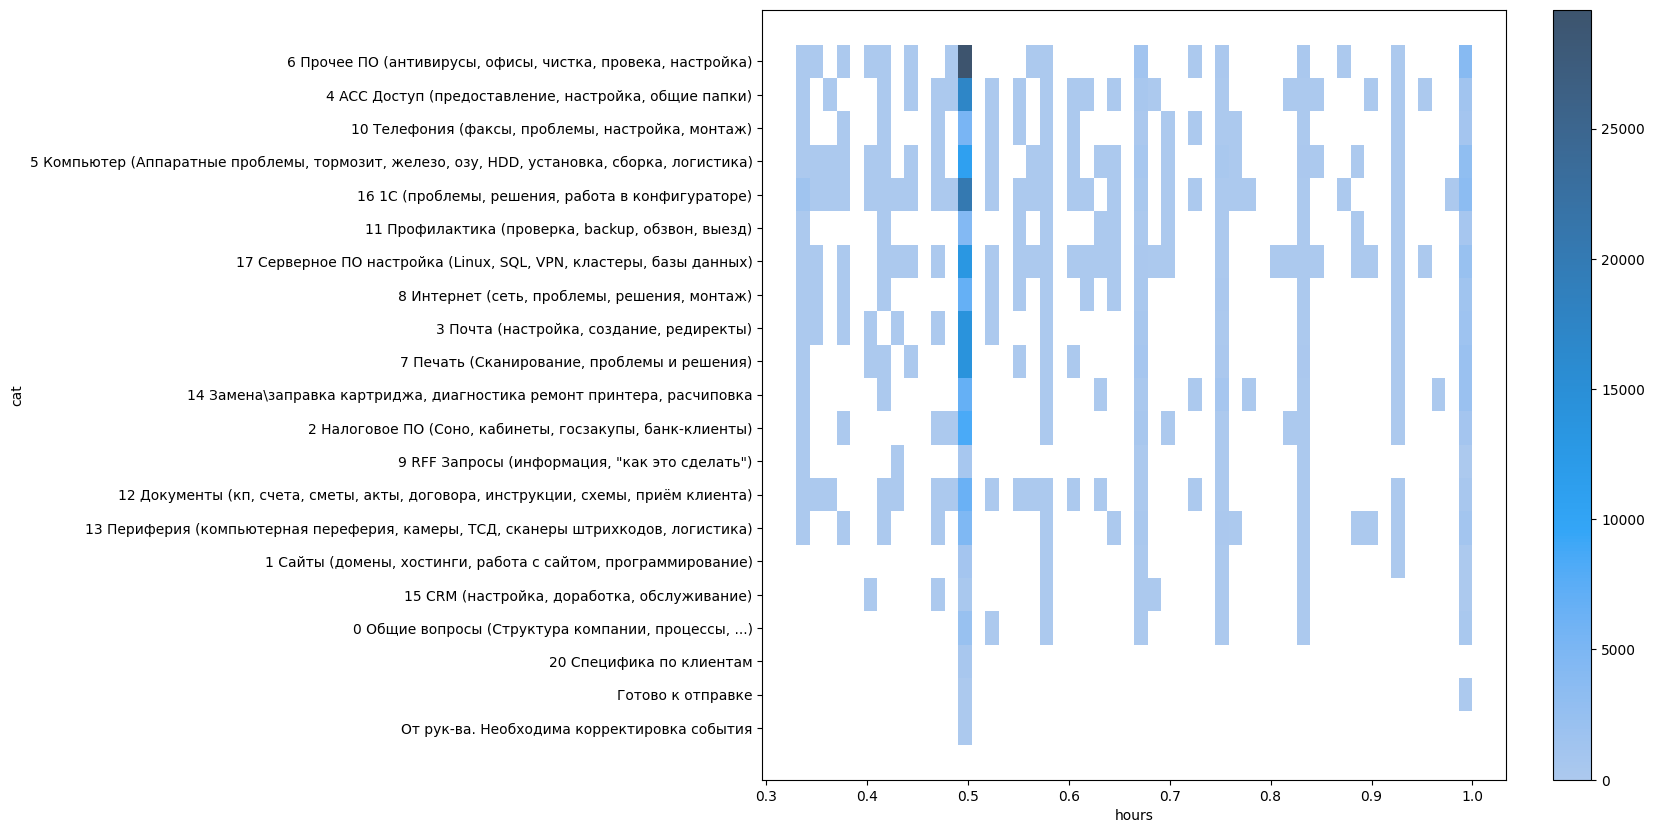

In [38]:
threshold_l = data_crm_clear_iqr['hours'].quantile(0.05)
threshold_h = data_crm_clear_iqr['hours'].quantile(0.95)
data_crm_clear_iqr_tr = data_crm_clear_iqr[(data_crm_clear_iqr['hours'] >= threshold_l) & (data_crm_clear_iqr['hours'] <= threshold_h)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
plt.subplots_adjust(hspace=0)

sns.histplot(
    data=data_crm_clear_iqr_tr,
    x='hours',
    y='cat',
    bins=50,
    cbar=True
)

In [40]:
data_plot = data_crm_clear[['id_ticket', 'client', 'start', 'end', 'department', 'cat', 'norm', 'hours']]

In [53]:
correlation = data_plot['norm'].corr(data_plot['hours'])
correlation

0.9999948002339901

In [45]:
data_plot.iloc[83557]

id_ticket                  ce83cf1d-27da-11eb-8105-c4346b227f9c
client         А02 ТОО IT Support Group (ITSG, саппорт, сапо...
start                                       2020-11-16 13:10:00
end                                         2020-12-28 12:35:00
department                                                  АУП
cat           13 Периферия (компьютерная переферия, камеры, ...
norm                                                    1078588
hours                                                    862.87
Name: 83557, dtype: object

In [48]:

data_plot = data_plot.drop(83557)

In [49]:
data_plot.loc[:, 'month'] = [x.month for x in data_plot['start']]
data_plot.loc[:, 'year'] = [x.year for x in data_plot['start']]

In [128]:
data_plot.head()

,start,department,cat,norm,hours,month,year
0,2019-01-03 08:52:00,Выездные специалисты,"16 1С (проблемы, решения, работа в конфигураторе)",0,0.0,1,2019
1,2019-01-03 08:57:00,Маслодел,"6 Прочее ПО (антивирусы, офисы, чистка, провек...",6,0.5,1,2019
2,2019-01-03 08:58:00,АУП,"16 1С (проблемы, решения, работа в конфигураторе)",0,0.0,1,2019
3,2019-01-03 09:00:00,Отдел активных продаж,"4 ACC Доступ (предоставление, настройка, общие...",6,0.5,1,2019
4,2019-01-03 09:03:00,1-линия,"6 Прочее ПО (антивирусы, офисы, чистка, провек...",6,0.5,1,2019


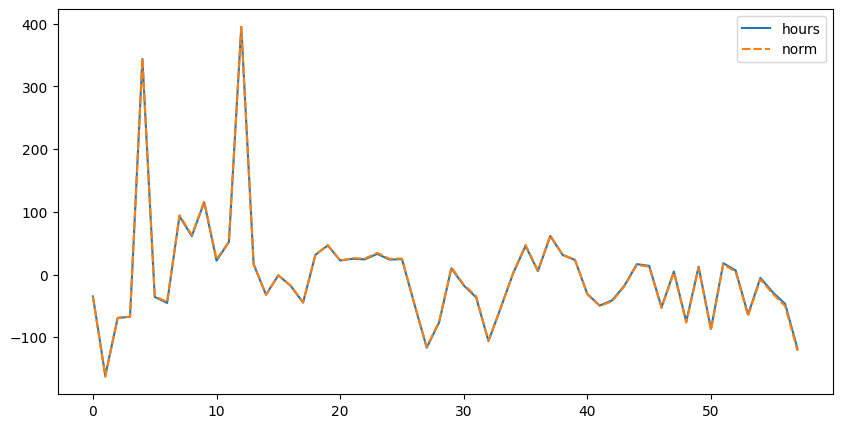

In [50]:
data_plot['norm'] = (data_plot['norm'] - data_plot['norm'].mean()) / data_plot['norm'].std()
data_plot['hours'] = (data_plot['hours'] - data_plot['hours'].mean()) / data_plot['hours'].std()

data_plt = data_plot.groupby(['year', 'month'])[['hours', 'norm']].sum()

data_plt = data_plt.reset_index()

fig = plt.figure(figsize=(10, 5))
lineplot = sns.lineplot(data=data_plt[['hours','norm']])

In [51]:
# Загружаем базу Кердеваре, именуем колонки
df_kerd = pd.read_csv('raw_data/goszakup_20230606_enriched_active.csv',
                      names=['id', 'bin', 'legal_form', 'name', 'start_date', 'contact_phone', 'email', 'drop', 'city', 'lpr', 'iin_lpr', 'size', 'oked', 'date2'],
                      header=None)

df_kerd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357699 entries, 0 to 357698
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             357699 non-null  int64  
 1   bin            357699 non-null  int64  
 2   legal_form     357699 non-null  object 
 3   name           357694 non-null  object 
 4   start_date     357699 non-null  object 
 5   contact_phone  349372 non-null  object 
 6   email          316297 non-null  object 
 7   drop           0 non-null       float64
 8   city           354217 non-null  object 
 9   lpr            357662 non-null  object 
 10  iin_lpr        357621 non-null  float64
 11  size           357699 non-null  object 
 12  oked           357699 non-null  object 
 13  date2          160414 non-null  object 
dtypes: float64(2), int64(2), object(10)
memory usage: 38.2+ MB


In [ ]:
 # нужно обогатить выгрузку ID устройства на каждой заявке и описанием устройства
 # обогатить выгрузку каналом по которому пришла заявка (телефон или асиста или письмо или профилактика (проактивность))
 # добавить бин клиента, количество человек в компании, количество ID на балансе

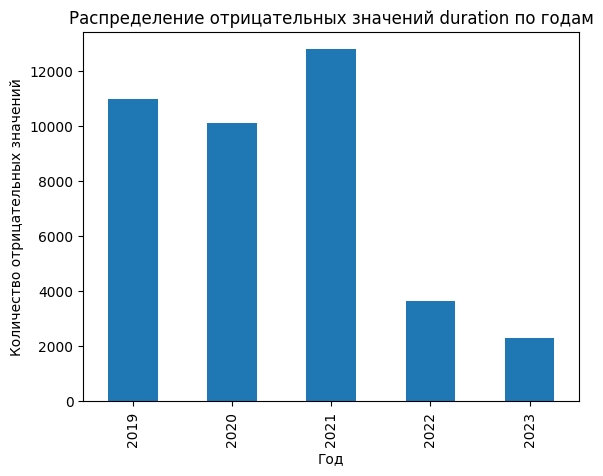

In [52]:
# Добавляем колонку 'year' если она еще не существует
# Предполагается, что есть колонка 'date' с datetime64[ns] типом данных
data_crm_clear['year'] = data_crm_clear['start'].dt.year

# Фильтруем только отрицательные значения duration
negative_durations = data_crm_clear[data_crm_clear['duration'] < pd.Timedelta(0)]

# Группируем данные по годам и подсчитываем количество отрицательных значений на каждый год
negative_counts_by_year = negative_durations.groupby('year').size()

# Строим график
negative_counts_by_year.plot(kind='bar')
plt.title('Распределение отрицательных значений duration по годам')
plt.xlabel('Год')
plt.ylabel('Количество отрицательных значений')
plt.show()

/var/folders/rd/k4w0k0_51ms9k7065r_6h99r0000gn/T/ipykernel_10249/2022584693.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_durations['duration_seconds'] = negative_durations['duration'].dt.total_seconds()


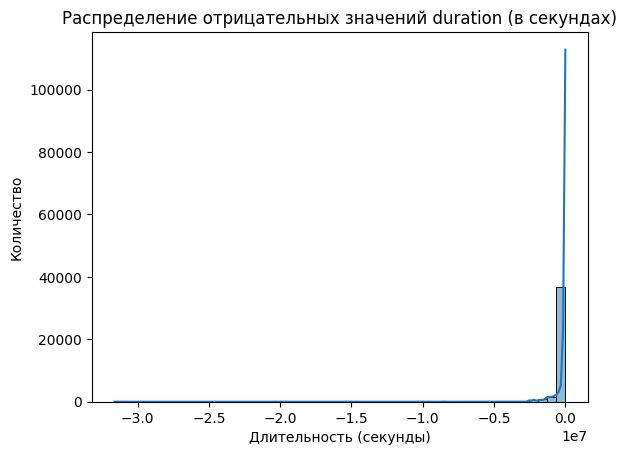

In [18]:
import seaborn as sns

# Предположим, что ваша колонка с длительностью называется 'duration'
# Фильтруем только отрицательные значения duration
negative_durations = data_crm_clear[data_crm_clear['duration'] < pd.Timedelta(0)]

# Преобразуем отрицательные значения duration в секунды
negative_durations['duration_seconds'] = negative_durations['duration'].dt.total_seconds()

# Используем seaborn для создания графика распределения
sns.histplot(negative_durations['duration_seconds'], bins=50, kde=True)

# Настраиваем график
plt.title('Распределение отрицательных значений duration (в секундах)')
plt.xlabel('Длительность (секунды)')
plt.ylabel('Количество')

# Отображаем график
plt.show()

In [22]:
data_crm_clear[data_crm_clear['duration'] < pd.to_timedelta(0)].head()

# есть дата создания, дата начала и дата окончания, надо брать дату начала и дату окончания

,index,id_ticket,parrent_id,start,end,it_name,department,cat,norm,hours,client,client_tin/bin,like,marks,del_mark,duration,year
11,12,0afbc1c8-0f09-11e9-80e0-c4346b227f9c,NaN,2019-01-03 09:38:00,2019-01-03 09:30:00,IT137 J&J Оглов Руслан,Джонсон,"11 Профилактика (проверка, backup, обзвон, выезд)",6,0.5,"A02 Джонсон & Джонсон (Johnson, Johnson&Johnso...",1.104420e+11,Дизлайк,Завершено,Нет,-1 days +23:52:00,2019
12,13,e49edab1-0f09-11e9-80e0-c4346b227f9c,NaN,2019-01-03 09:44:00,2019-01-03 09:30:00,IT128 Савёлов Иван,Выездные специалисты,"4 ACC Доступ (предоставление, настройка, общие...",6,0.5,R RG Brands РГБрендс ргбрендс ргб rgb,6.044000e+10,Дизлайк,Завершено,Нет,-1 days +23:46:00,2019
24,25,1af79df4-0f0d-11e9-80e0-c4346b227f9c,NaN,2019-01-03 10:07:00,2019-01-03 10:00:00,IT106 Азмаметов Фархат,МИТУ,"5 Компьютер (Аппаратные проблемы, тормозит, же...",6,0.5,"A02 ""Actual Optic"" (Актуал оптик, актуаль, опт...",2.044000e+10,Дизлайк,Завершено,Нет,-1 days +23:53:00,2019
50,51,c45ce4b5-0f16-11e9-80e0-c4346b227f9c,NaN,2019-01-03 11:16:00,2019-01-03 11:15:00,IT137 J&J Оглов Руслан,Джонсон,"7 Печать (Сканирование, проблемы и решения)",6,0.5,"A02 Джонсон & Джонсон (Johnson, Johnson&Johnso...",1.104420e+11,Лайк,Завершено,Нет,-1 days +23:59:00,2019
52,53,84e3dc3d-0f17-11e9-80e0-c4346b227f9c,NaN,2019-01-03 11:22:00,2019-01-03 11:00:00,IT128 Савёлов Иван,Выездные специалисты,"16 1С (проблемы, решения, работа в конфигураторе)",6,0.5,R RG Brands РГБрендс ргбрендс ргб rgb,6.044000e+10,Дизлайк,Завершено,Нет,-1 days +23:38:00,2019


In [23]:
data_buh.head()

,index,id_realisation,date_issued,company_name,company_bin,item,price,quant,summ_corr,seller,Unnamed: 10
0,1,1c6a7ceb-0fd0-11e9-80e0-c4346b227f9c,1/4/19 11:39,БрИиГ ТОО,3.014000e+10,SIP - телефон Yealink W52P DECT (база+трубка),45000,1,45000,"ТОО "" IT SUPPORT GROUP """,NaN
1,2,d3037aaf-131f-11e9-80e0-c4346b227f9c,1/8/19 14:37,Charysh ТОО,1.310400e+11,Работа специалиста (удаленная поддержка),4000,2,8000,"ТОО "" IT SUPPORT GROUP """,NaN
2,3,41644f3c-13c7-11e9-80e0-c4346b227f9c,1/9/19 10:55,Clean air group ТОО,1.406400e+11,"UPS, SVC, V-600-L, Мощность 600ВА/360Вт, Диапа...",14500,1,14500,"ТОО "" IT SUPPORT GROUP """,NaN
3,4,41644f3e-13c7-11e9-80e0-c4346b227f9c,1/9/19 11:01,Unicase ТОО,1.010400e+11,"Внешний жесткий диск 2,5 2TB Transcend TS2TSJ2...",40000,1,40000,"ТОО "" IT SUPPORT GROUP """,NaN
4,5,41644f40-13c7-11e9-80e0-c4346b227f9c,1/9/19 11:02,Unicase ТОО,1.010400e+11,"Внешний жесткий диск 2,5 1TB Transcend TS1TSJ2...",27000,1,27000,"ТОО "" IT SUPPORT GROUP """,NaN


In [25]:
data_crm_clear['department'].value_counts()

department
1-линия                                   36017
Серверный специалист Windows (Виндовс)    26396
Выездные специалисты                      24109
Маслодел                                  21757
Проектный менеджер ITSG проектов          16224
3-линия                                   15744
2-линия                                   13805
АУП                                        9561
Сервис                                     9548
Ремонт оргтехники                          8769
Travel Plus (Тревел плюс)                  7884
Проектный менеджер по клиентам             7548
ФудМастер (ФМ)                             7404
Серверные специалисты                      6805
Отдел активных продаж                      5302
Альстом (Алм)                              4370
Серверный специалист Linux (Линукс)        3864
Шымкент                                    3603
JTI (ДжиТиАй)                              3562
Бухгалтерия                                3439
Отдел продаж 2-я линия       